# Import the important packages

In [1]:
import numpy as np
from PIL import Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset

In [2]:
#print the number of images per folder in our dataset

print('The number of training Earth images: ', len(os.listdir('Dataset/Train/Earth/')))
print('The number of training Flare images: ', len(os.listdir('Dataset/Train/Flare/')))
print('The number of training Space images: ', len(os.listdir('Dataset/Train/Space/')))
print('Total: ', len(os.listdir('Dataset/Train/Earth/')) + len(os.listdir('Dataset/Train/Flare/')) + len(os.listdir('Dataset/Train/Space/')))

print('\nThe number of validation Earth images: ', len(os.listdir('Dataset/Test/Earth/')))
print('The number of validation Flare images: ', len(os.listdir('Dataset/Test/Flare/')))
print('The number of validation Space images: ', len(os.listdir('Dataset/Test/Space/')))
print('Total: ', len(os.listdir('Dataset/Test/Earth/')) + len(os.listdir('Dataset/Test/Flare/')) + len(os.listdir('Dataset/Test/Space/')))


The number of training Earth images:  232
The number of training Flare images:  101
The number of training Space images:  142
Total:  475

The number of validation Earth images:  50
The number of validation Flare images:  8
The number of validation Space images:  38
Total:  96


# Perform data augmention

In [3]:
TRAINING_DIR = 'Dataset/Train/'
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=5,
                                                    class_mode='categorical',
                                                    target_size=(32, 32)) 

VALIDATION_DIR = 'Dataset/Test/'
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=2,
                                                    class_mode='categorical',
                                                    target_size=(32, 32)) 

Found 475 images belonging to 3 classes.
Found 96 images belonging to 3 classes.


# Load the pretrained model

In [4]:
pretrained_model = keras.models.load_model('Models\cifar10 model.h5')

print(pretrained_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        1

# Change the softmax to three classes

In [5]:
base_outputs = pretrained_model.layers[-6].output
x = layers.Dense(128, activation='relu', name='dense_2')(base_outputs)
x = layers.Dense(3, activation='softmax', name='softmax')(x)

model = keras.Model(inputs = pretrained_model.input, outputs = x)
   
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0     

# Using callback for early stopping

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!\n")
            self.model.stop_training = True

callbacks = myCallback()

# Train the model

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch = 6,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[EarlyStopping(
                        patience=20,
                        mode='min',
                        monitor='val_loss',
                        restore_best_weights=True,
                        verbose=1)
                              ])


Epoch 1/100
6/6 [==============================] - 4s 227ms/step - loss: 1.0429 - accuracy: 0.3652 - val_loss: 0.6630 - val_accuracy: 0.9167
Epoch 2/100
6/6 [==============================] - 0s 55ms/step - loss: 0.5824 - accuracy: 0.8710 - val_loss: 0.2751 - val_accuracy: 0.9167
Epoch 3/100
6/6 [==============================] - 0s 55ms/step - loss: 0.7266 - accuracy: 0.7200 - val_loss: 0.2194 - val_accuracy: 0.9167
Epoch 4/100
6/6 [==============================] - 0s 54ms/step - loss: 0.7099 - accuracy: 0.7181 - val_loss: 0.2288 - val_accuracy: 0.9167
Epoch 5/100
6/6 [==============================] - 0s 59ms/step - loss: 0.4981 - accuracy: 0.6843 - val_loss: 0.1695 - val_accuracy: 0.9583
Epoch 6/100
6/6 [==============================] - 0s 64ms/step - loss: 0.3043 - accuracy: 0.9586 - val_loss: 0.1467 - val_accuracy: 0.9583
Epoch 7/100
6/6 [==============================] - 0s 65ms/step - loss: 0.3833 - accuracy: 0.9219 - val_loss: 0.0848 - val_accuracy: 0.9688
Epoch 8/100
6/6 [==

6/6 [==============================] - 0s 62ms/step - loss: 0.0676 - accuracy: 0.9848 - val_loss: 0.0339 - val_accuracy: 0.9896
Epoch 60/100
6/6 [==============================] - 0s 51ms/step - loss: 0.3996 - accuracy: 0.9100 - val_loss: 0.0288 - val_accuracy: 0.9896
Epoch 61/100
6/6 [==============================] - 0s 55ms/step - loss: 0.2641 - accuracy: 0.9386 - val_loss: 0.0304 - val_accuracy: 1.0000
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping


# Visualize the training and Testing histories

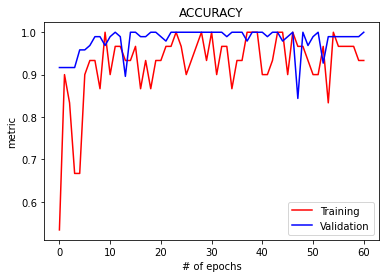

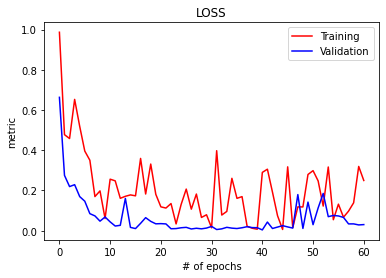

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('ACCURACY')
plt.ylabel('metric')
plt.xlabel('# of epochs')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('LOSS')
plt.ylabel('metric')
plt.xlabel('# of epochs')
plt.legend()

plt.show()

# Save and Load the model

In [9]:
model.save('Models\ICU_model.h5')

loaded_model = keras.models.load_model('Models\ICU_model.h5')

# Validate the model using external images

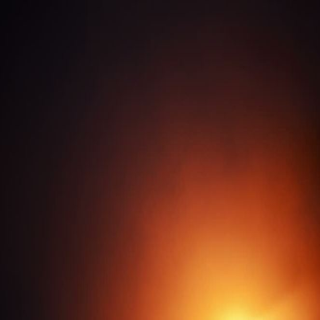

In [10]:
Sample = Image.open("Testing\Flare\Flare2.jpg").resize((320, 320))
Sample

In [11]:
Sample = Image.open("Testing\Flare\Flare2.jpg").resize((32,32));
Sample = np.array(Sample)/255.0;
Sample.shape;
Sample[np.newaxis, ...];
result = loaded_model.predict(Sample[np.newaxis, ...]);
predicted_label_index = np.argmax(result);
image_labels = []
with open("Dataset_Labels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:3]

image_labels[predicted_label_index]

'Flare'

# Convert the model to Tensorflow lite

In [12]:
converter = converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("Models\model_tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\chand\AppData\Local\Temp\tmp5yinvlwm\assets


373296